# Training with Large Datasets

In this notebook, we use the additional Google Maps data to train our models with much larger datasets. We first train the models on the additional dataset and then finetune them using the original dataset. We also try to apply some postprocessing using morphological operations. Don't forget to run the *google_maps_processing.ipynb* notebook first!

In [1]:
import os
from glob import glob
import torch
import cv2

from src.utils import *
from src.models import ResNet18UNet, ResNet50UNet, UNet
from src.pytorch_utils import *
from src.dataset_augmentation import augment_dataset

### Training with New Dataset
Let us create a validation and training set. With the current settings in *google_maps_processsing.ipynb*, 72 new samples are created from each of the 180 original images in the *large* directory. For every 720 images, we will use 1\*72 images for the validation set and 9\*72 for the training set. This way, our validation set will be nicely balanced since our new dataset consists of satellite images from many different locations.

In [2]:
def get_google_training_set():  
    # get filenames of all the training samples from the new Google Maps dataset
    image_fns = sorted(glob(os.path.join("training_google", "images", "*.png")))
    mask_fns = sorted(glob(os.path.join("training_google", "groundtruth", "*.png")))

    image_fns_train = []
    mask_fns_train = []
    image_fns_val = []
    mask_fns_val = []

    n_samples_per_large_img = 72
    for i in range(180):
        curr_img_fns = image_fns[i * n_samples_per_large_img : (i + 1) * n_samples_per_large_img]
        curr_mask_fns = mask_fns[i * n_samples_per_large_img : (i + 1) * n_samples_per_large_img]

        if i % 10 == 0:
            image_fns_val = image_fns_val + curr_img_fns
            mask_fns_val = mask_fns_val + curr_mask_fns
        else:
            image_fns_train = image_fns_train + curr_img_fns
            mask_fns_train = mask_fns_train + curr_mask_fns
    
    return image_fns_train, mask_fns_train, image_fns_val, mask_fns_val

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

image_fns_train, mask_fns_train, image_fns_val, mask_fns_val = get_google_training_set()

resnet_unet = ResNet18UNet(pretrained=True).to(device)
history = train_model(
    model=resnet_unet,
    image_fns_train=image_fns_train,
    mask_fns_train=mask_fns_train,
    image_fns_val=image_fns_val,
    mask_fns_val=mask_fns_val,
    n_epochs=20,
    batch_size=4,
    resize_shape=(384, 384),
)

os.makedirs("model_backups", exist_ok=True)
torch.save(resnet_unet.state_dict(), os.path.join("model_backups", "resnet18_unet_google_dataset")) 

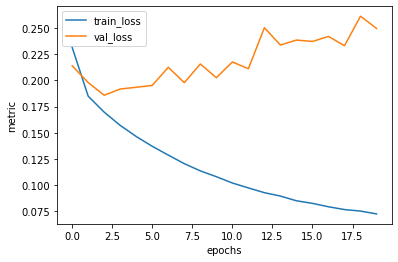

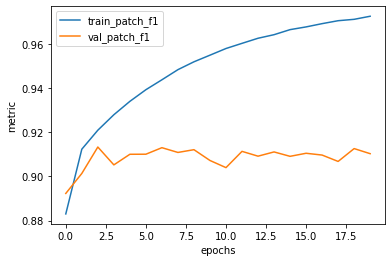

In [4]:
plot_training_history(history)

### Finetuning with Original Dataset
No let us finetune the model with the **full** original dataset. Ignore the validation scores here!

In [5]:
augment_dataset(
    imgs=load_pil_images(os.path.join("training", "images")), 
    masks=load_pil_images(os.path.join("training", "groundtruth")),
    n_samples_per_img=10,
    dir="training_ext",
)

Image 1440/1440


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# load weights trained on additional maps data
resnet_unet = ResNet18UNet().to(device)
resnet_unet.load_state_dict(torch.load(os.path.join("model_backups", "resnet18_unet_google_dataset")))

# get filenames of all the training samples from the original dataset
image_fns = sorted(glob(os.path.join("training_ext", "images", "*.png")))
mask_fns = sorted(glob(os.path.join("training_ext", "groundtruth", "*.png")))

# finetuning with FULL dataset => ignore validation scores
history = train_model(
    model=resnet_unet,
    image_fns_train=image_fns,
    mask_fns_train=mask_fns,
    image_fns_val=image_fns[-100:],
    mask_fns_val=mask_fns[-100:],
    n_epochs=3,
    batch_size=4,
    resize_shape=(384, 384),
)

os.makedirs("model_backups", exist_ok=True)
torch.save(resnet_unet.state_dict(), os.path.join("model_backups", "resnet18_unet_google_dataset_finetuned")) 

In [ ]:
preds = predict_on_test_set(
    resnet_unet, 
    resize_shape=(384, 384), 
    submission_fn="resnet18_unet_google_transfer_learning.csv")
plot_predictions(preds)

When we predict on the test set with the finetuned model, we get a public score of 0.915. Let us repeat the experiment with the baseline model and another ResNet-UNet version.

### Baseline Model

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

image_fns_train, mask_fns_train, image_fns_val, mask_fns_val = get_google_training_set()

unet = UNet().to(device)
history = train_model(
    model=unet,
    image_fns_train=image_fns_train,
    mask_fns_train=mask_fns_train,
    image_fns_val=image_fns_val,
    mask_fns_val=mask_fns_val,
    n_epochs=20,
    batch_size=4,
    resize_shape=(384, 384),
)

os.makedirs("model_backups", exist_ok=True)
torch.save(unet.state_dict(), os.path.join("model_backups", "unet_google_dataset")) 

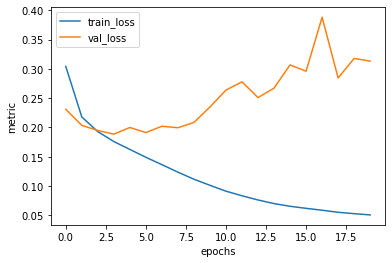

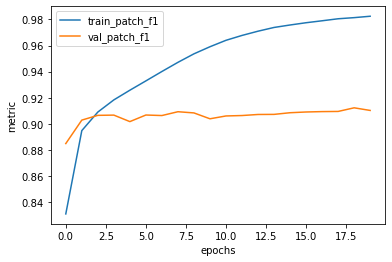

In [4]:
plot_training_history(history)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# load weights trained on additional maps data
unet = UNet().to(device)
unet.load_state_dict(torch.load(os.path.join("model_backups", "unet_google_dataset")))

# get filenames of all the training samples from the original dataset
image_fns = sorted(glob(os.path.join("training_ext", "images", "*.png")))
mask_fns = sorted(glob(os.path.join("training_ext", "groundtruth", "*.png")))

# finetuning with FULL dataset => ignore validation scores
history = train_model(
    model=unet,
    image_fns_train=image_fns,
    mask_fns_train=mask_fns,
    image_fns_val=image_fns[-100:],
    mask_fns_val=mask_fns[-100:],
    n_epochs=4,
    batch_size=4,
    resize_shape=(384, 384),
)

In [ ]:
preds = predict_on_test_set(
    unet, 
    resize_shape=(384, 384), 
    submission_fn="unet_google_transfer_learning.csv")
plot_predictions(preds)

Unfortunately, there is no improvement over the ResNet18-UNet model.

### Morphological Operations
Let us round the probabilistic segmentation maps to binary maps and apply the opening transformation (erosion followed by dilation).

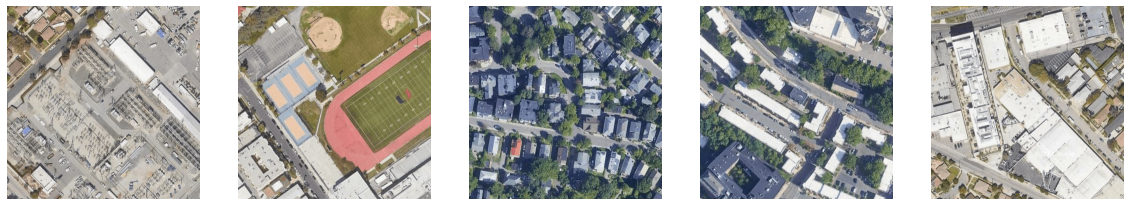

Probabilistic output:


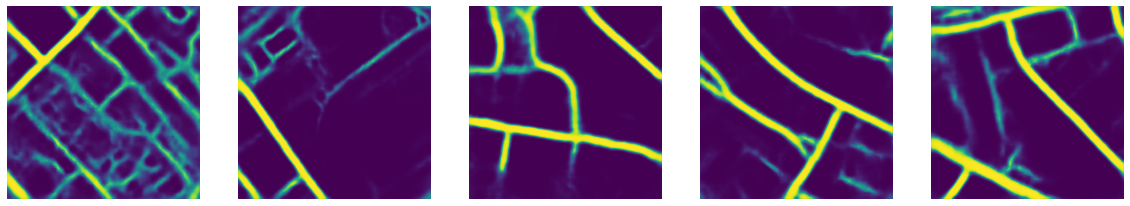

Rounded to binary images:


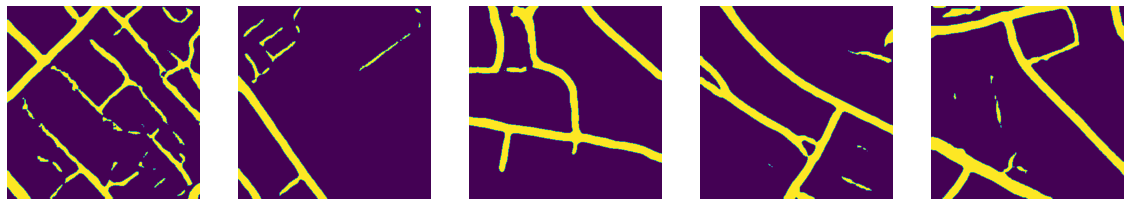

After erosion:


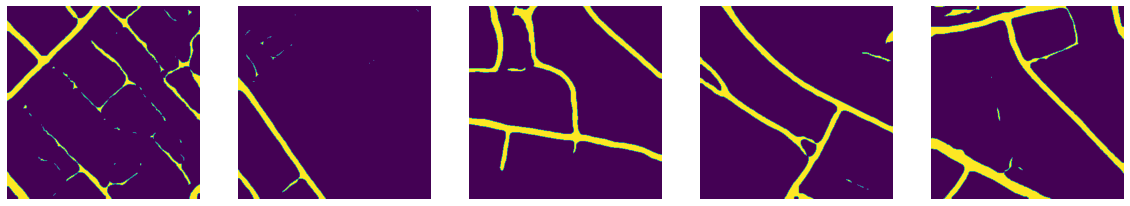

After dilation:


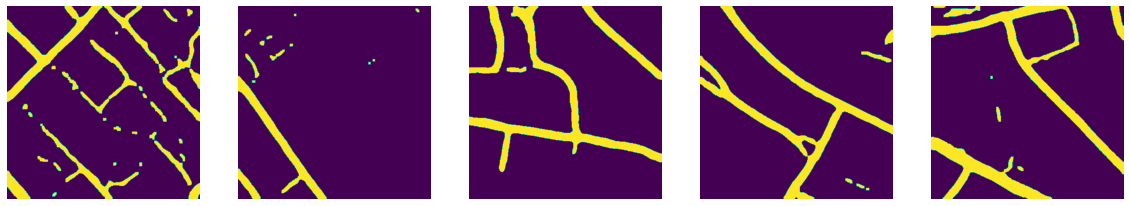

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# load weights of finetuned model
resnet_unet = ResNet18UNet().to(device)
resnet_unet.load_state_dict(torch.load(os.path.join("model_backups", "resnet18_unet_google_dataset_finetuned")))

preds = predict_on_test_set(
    resnet_unet, 
    resize_shape=(384, 384), 
    make_submission=False,
)

test_images = load_images(os.path.join("test", "images"))[:5]
plot_images(test_images)

print("Probabilistic output:")
plot_images([p for p in preds[:5]])

print("Rounded to binary images:")
preds = np.round(preds).astype(np.uint8)
plot_images([p for p in preds[:5]])

print("After erosion:")
kernel = np.ones((5, 5), np.uint8)
preds = np.array([cv2.erode(p, kernel, iterations=1) for p in preds])
plot_images([p for p in preds[:5]])

print("After dilation:")
kernel = np.ones((5, 5), np.uint8)
preds = np.array([cv2.dilate(p, kernel, iterations=1) for p in preds])
plot_images([p for p in preds[:5]])


In [ ]:
plot_predictions(preds)

In [4]:
compute_labels_and_create_submission(preds.astype(np.float32), submission_fn='resnet18_unet_google_transfer_learning_postprocessed.csv')

Created submission file: submissions\resnet18_unet_google_transfer_learning_postprocessed.csv


Unfortunately, the postprocessing does not help much.